In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
data = bmb.load_data("sleepstudy")

In [4]:
model = bmb.Model("Reaction ~ Days + (Days | Subject)", data)
model

Formula: Reaction ~ Days + (Days | Subject)
Family name: Gaussian
Link: identity
Observations: 180
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 298.5079, sigma: 261.0092)
    Days ~ Normal(mu: 0.0, sigma: 48.8915)

  Group-level effects
    1|Subject ~ Normal(mu: 0, sigma: HalfNormal(sigma: 261.0092))
    Days|Subject ~ Normal(mu: 0, sigma: HalfNormal(sigma: 48.8915))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 56.1721)


In [5]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Reaction_sigma, Days|Subject_offset, Days|Subject_sigma, 1|Subject_offset, 1|Subject_sigma, Days, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [6]:
az.summary(idata, var_names=["Intercept", "Days"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,251.548,7.372,237.862,264.428,0.222,0.157,1110.0,1237.0,1.0
Days,10.488,1.730,7.159,13.741,0.072,0.052,573.0,741.0,1.0


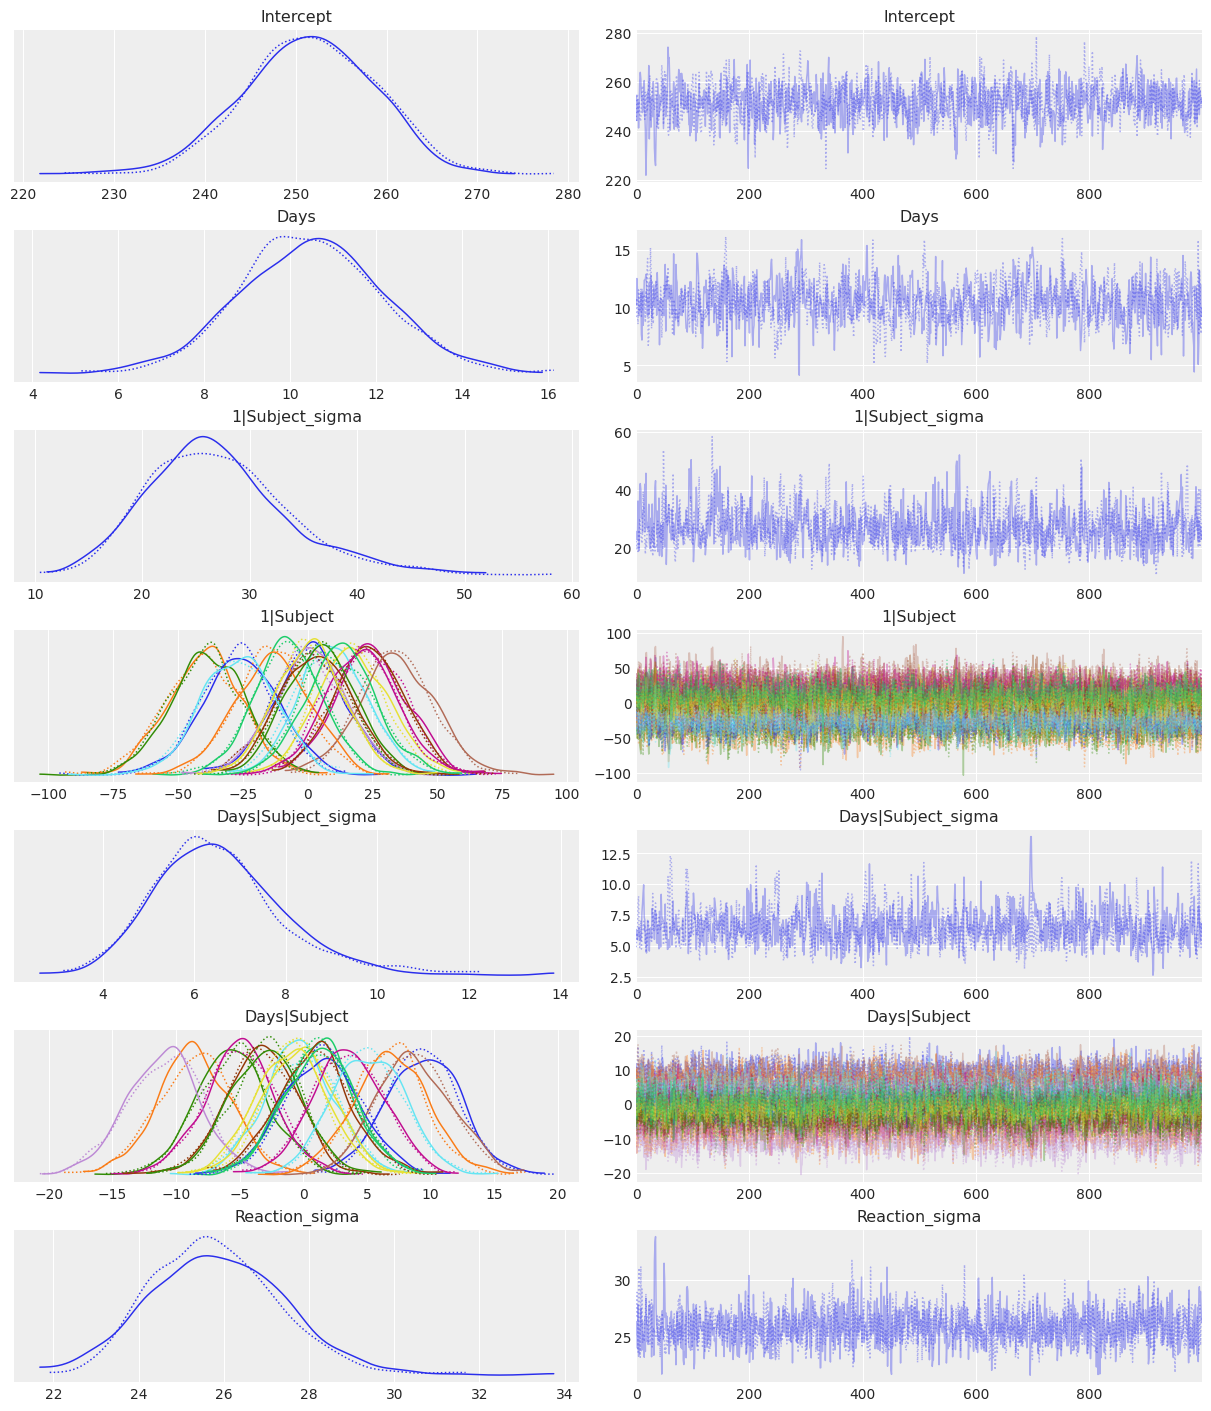

In [7]:
az.plot_trace(idata);

In [8]:
data

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


In [9]:
model.predict(idata)

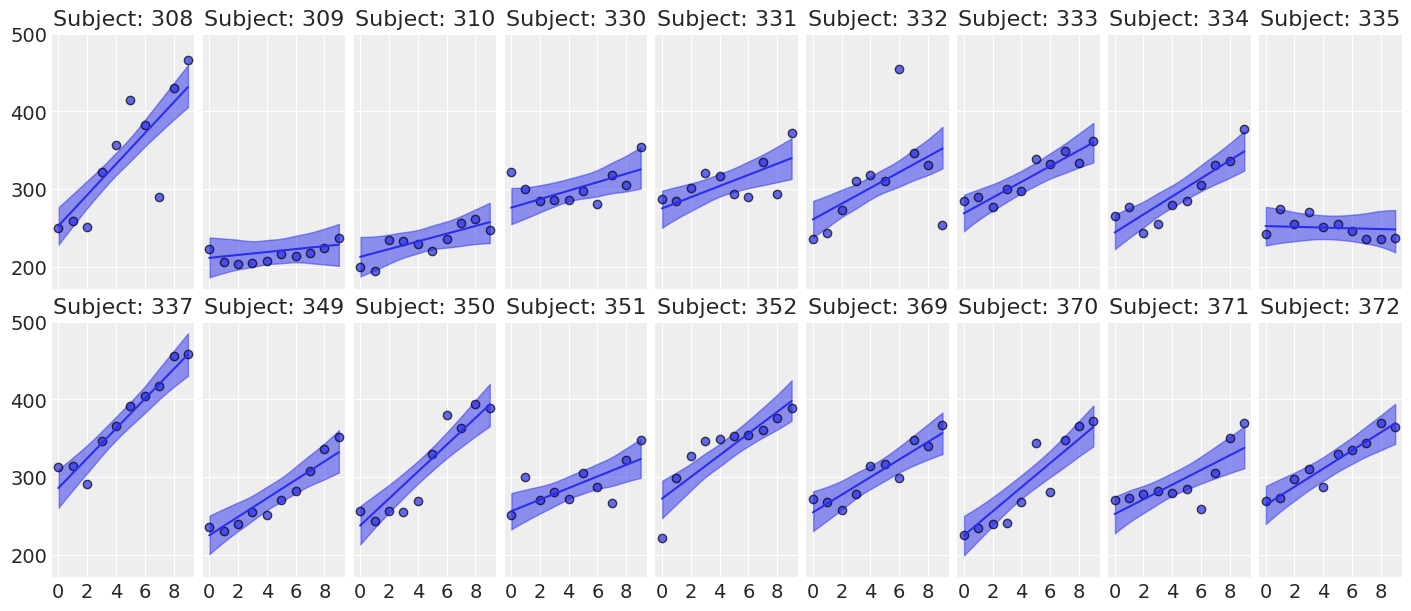

In [10]:
_, axes = plt.subplots(2, 9, figsize=(14, 6), sharey=True, sharex=True)

axes = axes.ravel()

# Take the posterior of the mean reaction time
reaction_mean = idata.posterior["Reaction_mean"].values

for i, subject in enumerate(data["Subject"].unique()):
    # Grab axis
    ax = axes[i]

    # Select data that goes in each axis
    idx = data.index[data["Subject"]== subject].tolist()
    days = data.loc[idx, "Days"].values
    reaction = data.loc[idx, "Reaction"].values

    # Plot highest density interval
    az.plot_hdi(days, reaction_mean[:, :, idx], color="C0", ax=ax)
    
    # Plot predicted regression equation
    ax.plot(days, reaction_mean[:, :, idx].mean(axis=(0, 1)), color="C0")

    # Plot observed data points
    ax.scatter(days, reaction, color="C0", ec="black", alpha=0.7)
    
    # Add a title
    ax.set_title(f"Subject: {subject}")

ax.xaxis.set_ticks([0, 2, 4, 6, 8]);